# INTRODUCTION TO MACHINE LEARNING PROJECT

## Imports

In [138]:
import numpy as np
import math 
import random
import matplotlib.pyplot as plt

# NOTES
# TODO show that the train test creation is really random, i.e that every class has 1/3 chance of being the majority class over all the dataset
# TODO make doxygen-like comments ?
# TODO confirm the experimental results with theoretical results
# TODO not sure normalization is needed for the features ?
# TODO weighting the closest points ?
# TODO improve calculations by using linear algebra 
# TODO calculate variance and std to know the right number of folds

## Loading Data

In [139]:
def load_data(dataset_file):
    return np.loadtxt(dataset_file, delimiter=',')

data = load_data('./waveform.data')

# Splitting the features and the labels into two different arrays
features = np.array(data[:,:data.shape[1]-1])

# Normalization of the features
def normalization(feat_to_norm) :
    new = np.empty(shape=feat_to_norm.shape)
    for i in range(feat_to_norm.shape[1]) :
        mean = np.mean(feat_to_norm[:,i])
        std = np.std(feat_to_norm[:,i])
        new[:,i] = (feat_to_norm[:,i] - mean) / std
    return new

features = normalization(feat_to_norm=features)    

labels = np.array(data[:,data.shape[1]-1:])

###  Creating the dataset in python

In [140]:
def train_test_split(features, labels, train_ratio):
    assert features.shape[0] == labels.shape[0], "Error : dimensions of features and labels should be the same"

    # Randomly shuffling the dataset's indices to pick randomly the training and test examples
    shuffled_indices = np.arange(features.shape[0])
    np.random.shuffle(shuffled_indices)

    train_size = int(len(shuffled_indices) * train_ratio)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]
    print(train_indices)
    print(test_indices)

    x_set = features[train_indices]
    x_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]

    assert x_set.shape[0] == y_train.shape[0], "Error : creation of training set went wrong."
    assert x_test.shape[0] == y_test.shape[0], "Error : creation of testing set went wrong."

    return x_set, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(features, labels, 0.8)

print("Training set : "+str(x_train.shape[0])+" examples.\nTest set : "+str(x_test.shape[0])+" examples.")

[4313 3726 2016 ... 3906 3593 3190]
[2278 3223 2791 4667  995 1683 4741 3237 2883  818 2280 1511 1460 3656
  571 1218 4233  188 2788 4506 1323 3579 4964 2386  875 3182  719   52
 1629 2753 3021 1055 2481  673  606  394 2913  972 4190 2507 3455 4079
 4469 3814 2163 2759 3661 1428 1434 2172 4142 4656 3642  520 4065 3158
 2571 3867 3399  936 2794  708  232   94 4007 4348 1557 2622  672 3248
  887 3806 1204 3652 3314  933 2672 4844 3680 1573 4804 1393 2370 4470
 2614 2032  262 4845 4406 4835  668 1823 4688 4572 3570 2891 2265 3218
  402 3641  342 4099 3876  483  565 1961  997  139 3272 1816  696 3337
 4737 1248  273 2445  487 3892 4780 4591 3626  801  471 3212 4126 3780
 4308 4909 3329   85 2071 2589 2932  614 1499 2986 2992 1640 3621 3509
   18 2665 1140 1011 3769 3184 1364  287 1419 4692 1098 4471 4410  921
 4285  341 1860 4526 3250 1149 3701 1164  365 2640 2730 4304   53 3265
 2990 4492 2305 4750 3465 4318  633 3572 3367 1126 4361 3740 2662 1717
 4771 4793 2298 3045 2476  749 2975 3126 

### Various functions

In [141]:
# Returns the euclidian distance between the vectors x1 and x2
def euclidian_distance(x1, x2):
    assert len(x1) == len(x2), "Dimensions of x1 and x2 must be the same"

    return np.sqrt(np.sum((x2 - x1) ** 2))

# Returns an array with the distances from x to every x' in x_array
def distance_array(x, x_array):
    return np.linalg.norm(x_array - x, axis=1).reshape(-1, 1)

def accuracy(nb_true, nb_total):
    return (nb_true * 100) / nb_total

## KNN Algorithm

In [142]:
# Returns the majority class from the features amongst the k nearest neighbors of new_input 
def knn(new_input, features, labels, k):
    # Computing the distance from new_input to every x in features
    dist_array = distance_array(new_input, features)

    # Associating the distance array with their corresponding labels
    dist_array_labeled = np.hstack([dist_array, labels])

    # Sorting the array by increasing distance order (keeping the labels associated)
    sorted_indices = np.argsort(dist_array_labeled[:, 0])
    sorted_array = dist_array_labeled[sorted_indices]

    # Count the number of occurences of each class Yj among the k nearest neighbors
    label, counts = np.unique(sorted_array[:k, 1], return_counts=True, axis=0)
    results = dict(zip(label, counts))

    # Returning the majority class among the k nearest neighbors
    majority_class = max(results, key=results.get)
    return majority_class

# Returns the accuracy of the prediction over the entire x_set for k nearest neighbors
def prediction(x_set, y_set, k):
    right_predictions = 0
    total_predictions = len(x_set)

    for i in range(total_predictions) :
        # Take the example predicted out as we don't want his class taken into account
        new_x_train = np.delete(x_set, i, axis=0)
        new_y_train = np.delete(y_set, i, axis=0)

        y_pred = knn(x_set[i], new_x_train, new_y_train, k)
        y_actual = y_set[i, 0]

        if (y_pred == y_actual):
            right_predictions +=1

    accuracy = (right_predictions * 100) / total_predictions
    return accuracy

## Tuning k by cross-validation

In [151]:
#Splitting the training set into x_subsets for cross-validation
def k_folds(x_training_set, y_training_set, nb_folds):
    # Shuffling the sets to get random folds
    indices = np.arange(x_training_set.shape[0])
    np.random.shuffle(indices)
    x_shuffled = x_training_set[indices]
    y_shuffled = y_training_set[indices]
    
    # Split the shuffled data into folds
    x = np.array_split(x_shuffled, nb_folds)
    y = np.array_split(y_shuffled, nb_folds)

    assert len(x) == len(y), "Error creating the subsets for cross-validation"
    return x, y

# Returns the mean accuracy for a given k over all the folds
def cross_validation(k, x_train_folds, y_train_folds, nb_folds):
    fold_accuracies = []

    for n in range(nb_folds):
        x_val_fold = x_train_folds[n]
        y_val_fold = y_train_folds[n]

        fold_accuracy = (prediction(x_val_fold, y_val_fold, k))
        fold_accuracies.append(fold_accuracy)
        print("Validation fold "+str(n))
        print("k = "+str(k)+" acc = "+str(fold_accuracy))

    mean_accuracy = np.mean(fold_accuracies)
    return mean_accuracy


nb_folds = 5
x_subsets, y_subsets = k_folds(x_train, y_train, nb_folds)
k_range = range(1, 100)
accuracies = []

for k in k_range : 
    mean_acc = cross_validation(k, x_subsets, y_subsets, nb_folds)

    accuracies.append(mean_acc)  
    print("k = "+str(k)+" mean accuracy = "+str(mean_acc))

TypeError: 'float' object is not iterable

### Plotting

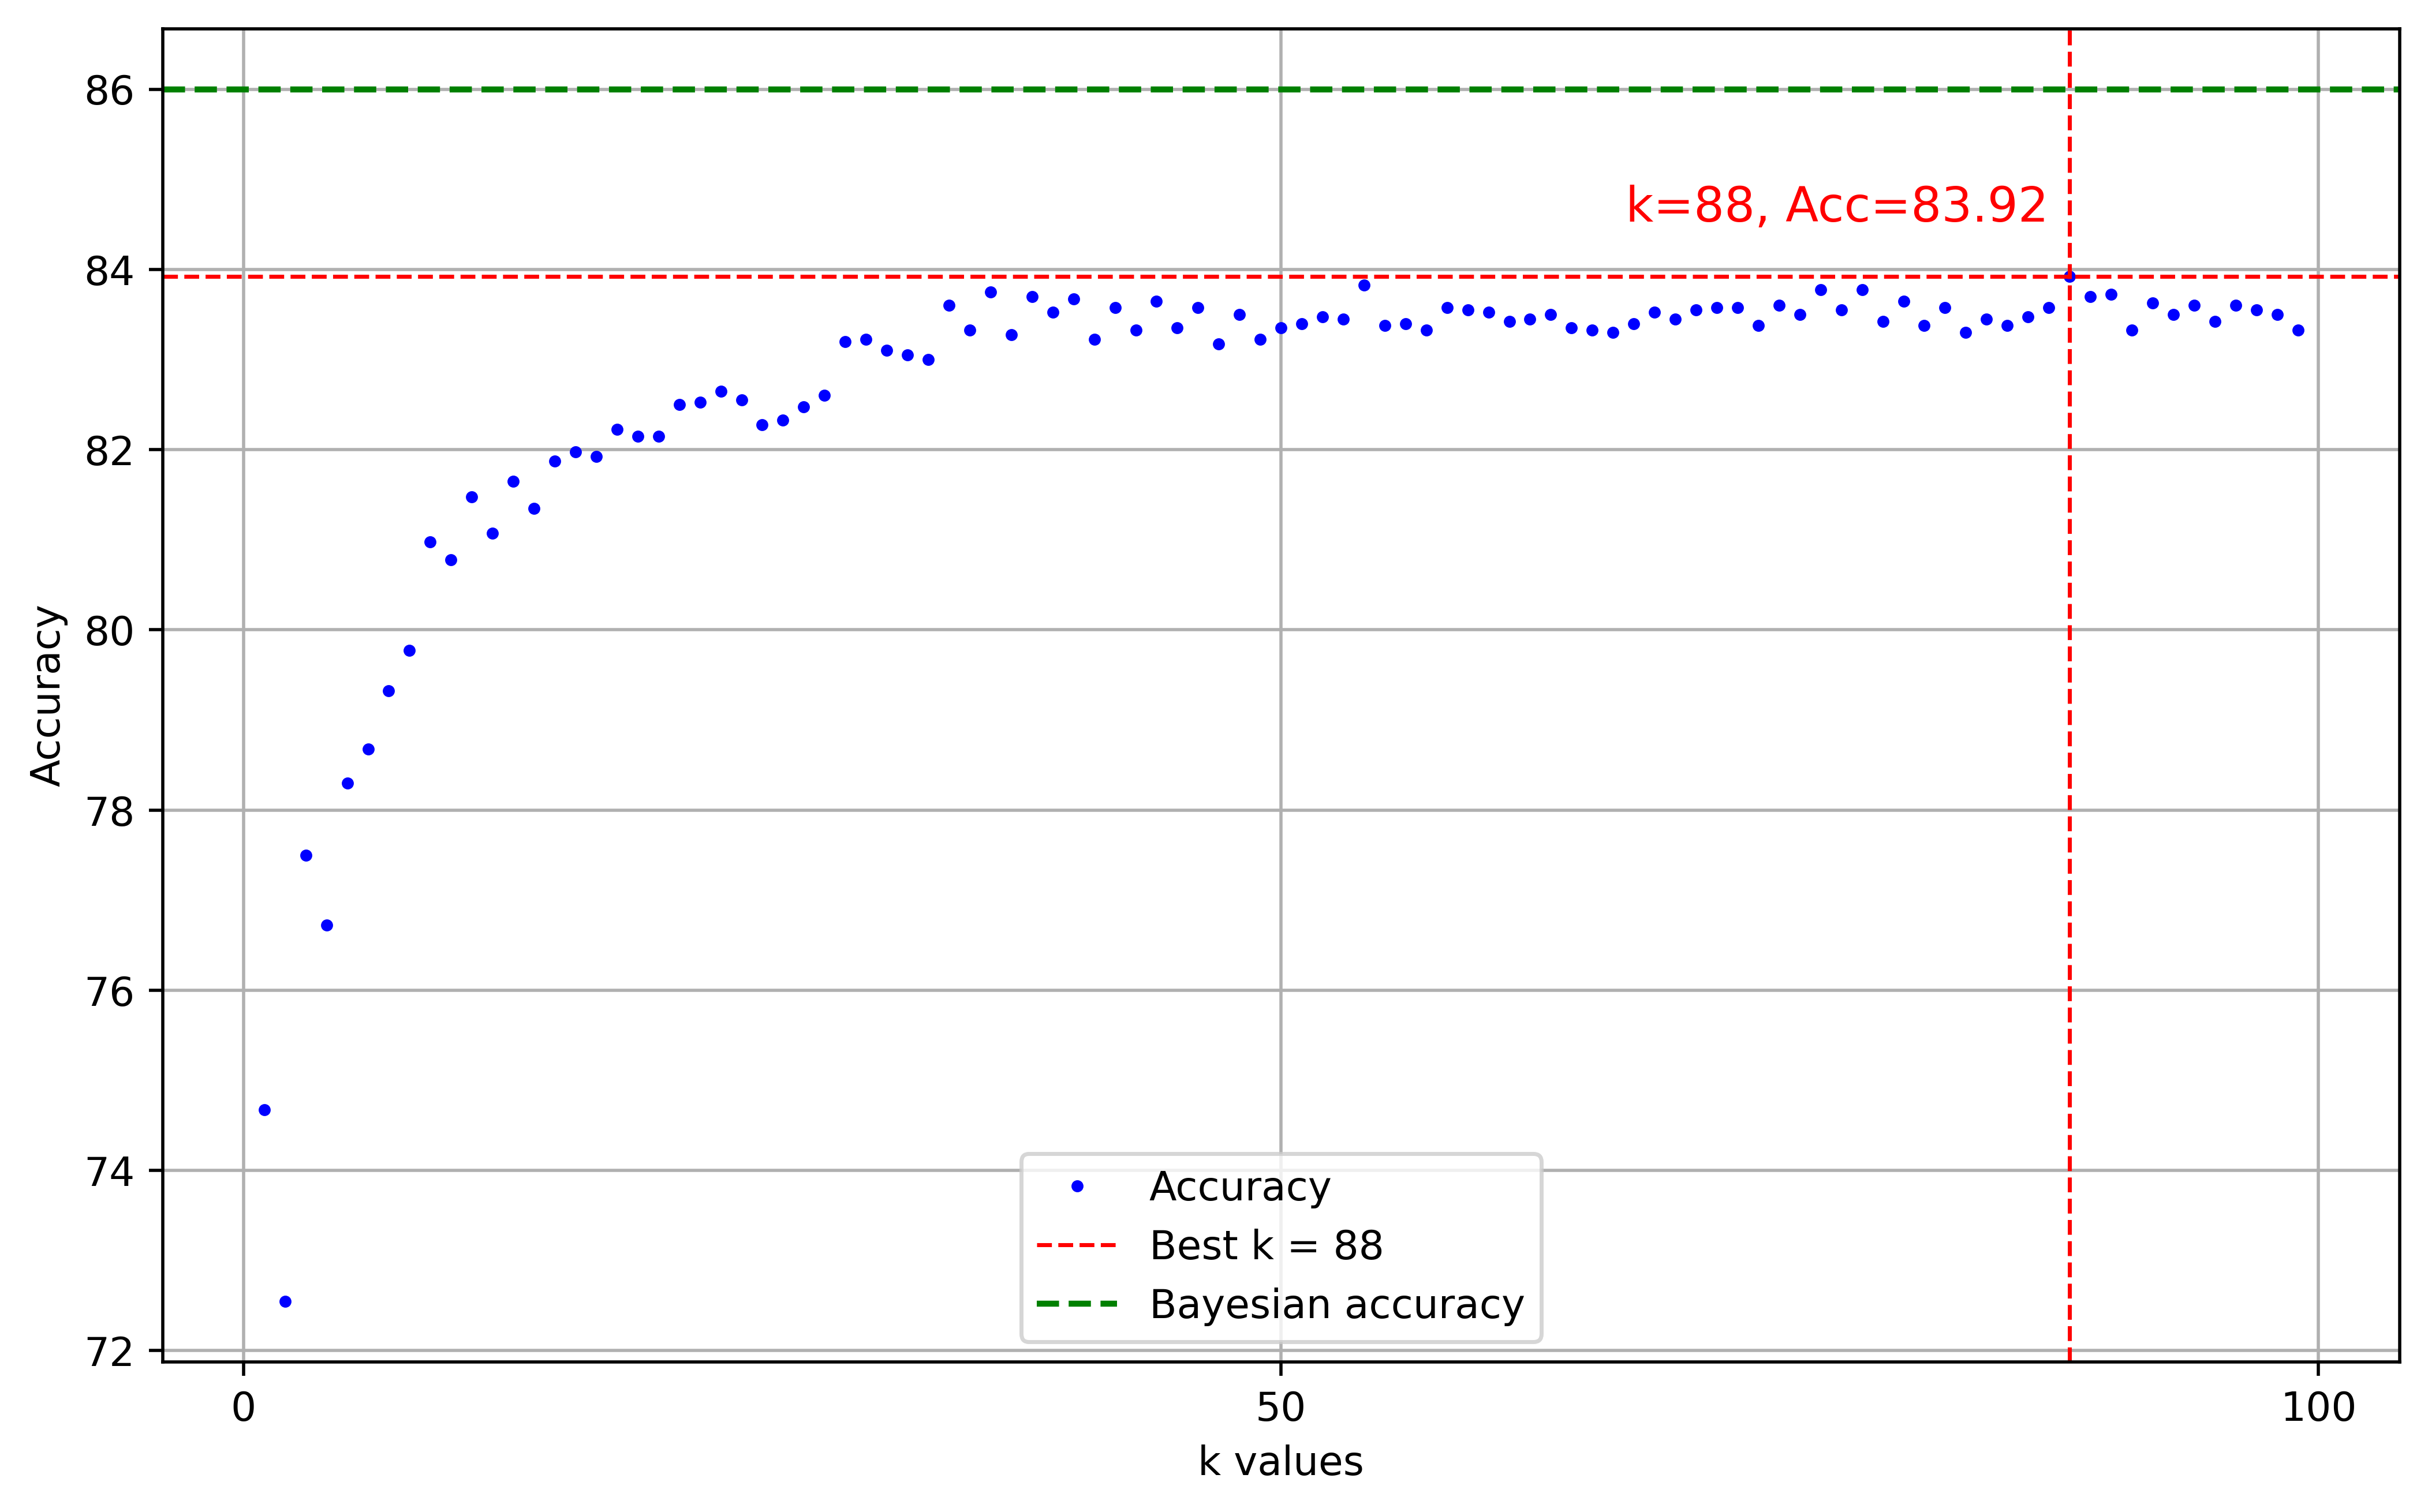

In [150]:
max_accuracy = max(accuracies)
best_k = k_range[accuracies.index(max_accuracy)] 

plt.figure(figsize=(10, 6), dpi=500) 
plt.plot(k_range, accuracies, label='Accuracy', marker='o', color='b',markersize=2,linestyle='None')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=1, label=f'Best k = {best_k}')
plt.axhline(y=max_accuracy, color='r', linestyle='--', linewidth=1)
plt.axhline(y=86, color='g', linestyle='--', label=f'Bayesian accuracy')
plt.text(best_k-1, max_accuracy+.5, f'k={best_k}, Acc={max_accuracy:.2f}', 
         horizontalalignment='right', verticalalignment='bottom', 
         color='red', fontsize=12)
plt.xlabel('k values')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, max(k_range)+2, 50)) 
plt.grid(True)
plt.legend()

plt.show()

In [145]:
#test prediction sur test set
print(prediction(x_test, y_test, 80))

85.3
